This notebook reproduces Figs. 3, 4, and S2.

In [ ]:
import os
import sys
import time
import csv
from importlib import reload
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import assay

import numpy as np
import scipy as sc

from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
plt.rcParams["font.size"] = 8

import seaborn as sns
sns.set_style('whitegrid', {'grid.color': '0.9'})

## Fig. 3

In [25]:
# compute distribution of true blue fitnesses for different lambdas
fitness_str = 'blue'
n_trains = [96, 192, 384]
lmbdas = [0, 2, 4, 6]
n_seed = 5000

ntrain2reg = {96:10, 192:1, 384: 1}
order = 2
data = assay.PoelwijkData(fitness_str, order=order)

bfit_txlxs = np.zeros([len(n_trains), len(lmbdas), n_seed])
t0 = time.time()
for t, n_train in enumerate(n_trains):
    reg = ntrain2reg[n_train]
    model = Ridge(alpha=reg, fit_intercept=True)
    for seed in range(n_seed):

        # get uniformly random training data
        np.random.seed(seed)
        train_idx = np.random.choice(data.n, n_train, replace=True)
        Xtrain_nxp, ytrain_n = data.X_nxp[train_idx, 1 :], data.y_n[train_idx]
        ytrain_n = data.get_measurements(train_idx)

        # train regression model
        model.fit(Xtrain_nxp, ytrain_n)

        for l, lmbda in enumerate(lmbdas):

            # construct test input distribution
            predall_n = model.predict(data.X_nxp[:, 1 :])
            punnorm_n = np.exp(lmbda * predall_n)
            Z = np.sum(punnorm_n)
            p_n = punnorm_n / Z

            # sample designed protein
            test_idx = np.random.choice(data.n, p=p_n, size=1)
            bfit_txlxs[t, l, seed] = data.get_measurements(test_idx)
                
    print('Done with n = {} ({:.1f} s)'.format(n_train, time.time() - t0))

Using 92 order-2 features
Loading estimated measurement noise SD computed using order 7 and significance level 0.01
Done with n = 96 (47.7 s)
Done with n = 192 (97.7 s)
Done with n = 384 (152.6 s)


In [27]:
# already saved
# np.savez('../blue-designed-fitness.npz', bfit_txlxs=bfit_txlxs)

In [2]:
d = np.load('../blue-designed-fitness.npz')
bfit_txlxs = d['bfit_txlxs']

In [3]:
# load all blue FCS and SCS results
n_trains = [96, 192, 384]
lmbdas = [0, 2, 4, 6]
n_seed = 2000
alpha = 0.1
y_interval = 0.02
ntrain2reg = {96:10, 192:1, 384: 1}


bfcov_txl = np.zeros([len(n_trains), len(lmbdas)])
bflen_txlxs = np.zeros([len(n_trains), len(lmbdas), n_seed])
bfsets_txl = [len(lmbdas) * [None] for _ in range(len(n_trains))]
bscov_txl = np.zeros([len(n_trains), len(lmbdas)])
bslen_txlxs = np.zeros([len(n_trains), len(lmbdas), n_seed])
bssets_txl = [len(lmbdas) * [None] for _ in range(len(n_trains))]
by_txlxs = np.zeros([len(n_trains), len(lmbdas), n_seed])
bpred_txlxs = np.zeros([len(n_trains), len(lmbdas), n_seed])

for t, n_train in enumerate(n_trains):
    reg = ntrain2reg[n_train]
    for l, lmbda in enumerate(lmbdas):
        
        fname = '../fluorescence/blue_n{}_lambda{}_alpha{}_gamma{}.npz'.format(
            n_train, lmbda, alpha, reg)
        d = np.load(fname, allow_pickle=True)
        
        # FCS results
        bfset_s = d['fset_s']
        bfsets_txl[t][l] = bfset_s
        bflen_txlxs[t, l] = [cs.size * y_interval for cs in bfset_s]
        bfcov_txl[t, l] = np.mean(d['fcov_s'])
        
        # SCS results
        bsset_s = d['sset_s']
        bssets_txl[t][l] = bsset_s
        bslen_txlxs[t, l] = [cs.size * y_interval for cs in bsset_s]
        bscov_txl[t, l] = np.mean(d['scov_s'])
        
        # true and predicted fitness of designed protein
        by_txlxs[t, l] = d['ytest_s']
        bpred_txlxs[t, l] = d['predtest_s']
        

In [4]:
# compute Jaccard distance between SCS and FCS confidence sets
def jaccard_similarity(list1, list2):
    if len(list1) == 0 and len(list2) == 0:
        return 1
    s1 = set(list1)
    s2 = set(list2)
    return float(len(s1.intersection(s2)) / len(s1.union(s2)))

bjacc_txlxs = np.zeros((len(n_trains), len(lmbdas), n_seed))
for t in range(len(n_trains)):
    for l in range(len(lmbdas)):
        for seed in range(n_seed):
            jacc = jaccard_similarity(bfsets_txl[t][l][seed], bssets_txl[t][l][seed])
            bjacc_txlxs[t, l, seed] = 1 - jacc

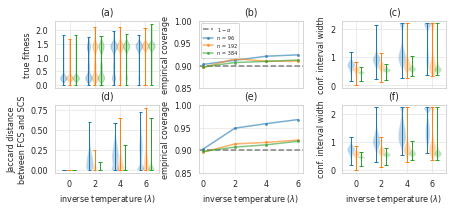

In [17]:
# plot and save figure
save_figure = True
fname = '../figures/100422/fig3-fluorescence.pdf'
alpha = 0.1  # miscoverage
vplot_lw = 1
plot_ms = 2
plot_lw = 1.5


# single-column width: 3.42 inches or 8.7 cm
# double-column width: 7 inches or 17.8 cm
# maximum height: 8.85 inches or 22.5 cm
# small: approx 9 cm x 6 cm (3.54 x 2.36 in)
# medium: approx 11 cm x 11 cm (4.33 in)
# large: approx 18 cm x 22 cm (7 x 8.66 in)
fig, axs = plt.subplots(2, 3, figsize=(7, 2.8))
fig.subplots_adjust(wspace=0.38, hspace=0.25)

# ===== distribution of fitness of designed proteins (a) =====

offsets = [-0.5, 0, 0.5]
colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

for t in range(len(n_trains)):
    ls = [l + offsets[t] for l in lmbdas]
    v = axs[0, 0].violinplot(bfit_txlxs[t].T, ls, widths=0.5, points=200, showextrema=True)
    add_label(v, "n = {}".format(n_trains[t]))
    for pc in v['bodies']:
        pc.set_color(colors[t])
    v['cbars'].set_linewidth(vplot_lw)
    v['cmins'].set_linewidth(vplot_lw)
    v['cmaxes'].set_linewidth(vplot_lw)
    

axs[0, 0].set_xticks(lmbdas)
axs[0, 0].set_xticklabels([])
axs[0, 0].set_ylabel('true fitness');
axs[0, 0].set_yticks([0, 0.50, 1.00, 1.50, 2]);
axs[0, 0].set_title('(a)');


# ===== Jaccard distance between FCS and CS (d) =====

offsets = [-1, 0, 1]
arrl = np.array(lmbdas)
for l, jacc_lxs in enumerate(bjacc_txlxs):
    v = axs[1, 0].violinplot(jacc_lxs.T, arrl + offsets[l] * 0.4, points=200, widths=0.6, showextrema=True)
    v['cbars'].set_linewidth(vplot_lw)
    v['cmins'].set_linewidth(vplot_lw)
    v['cmaxes'].set_linewidth(vplot_lw)
axs[1, 0].set_xlabel(r'inverse temperature ($\lambda$)');
axs[1, 0].set_xticks(lmbdas)
axs[1, 0].set_title('(d)');
axs[1, 0].set_ylabel('Jaccard distance\nbetween FCS and SCS');

# ===== FCS coverage (b) =====

axs[0, 1].axhline(1 - alpha, linestyle="--", color='gray', label=r'$1 - \alpha$')
for t, cov_l in enumerate(bfcov_txl):
    axs[0, 1].plot(lmbdas, cov_l, '-o', markersize=plot_ms, linewidth=plot_lw, alpha=0.6, label='n = {}'.format(n_trains[t]))

axs[0, 1].set_xticks(lmbdas)
axs[0, 1].set_xticklabels([])
axs[0, 1].set_ylabel('empirical coverage');
axs[0, 1].legend(fontsize=5, loc='upper left');
axs[0, 1].set_ylim([0.85, 1]);
axs[0, 1].set_title('(b)');

# ===== FCS interval width (c) =====

for l, len_lxs in enumerate(bflen_txlxs):
    v = axs[0, 2].violinplot(len_lxs.T, arrl + offsets[l] * 0.4, points=1000, widths=0.6, showextrema=True)
    v['cbars'].set_linewidth(vplot_lw)
    v['cmins'].set_linewidth(vplot_lw)
    v['cmaxes'].set_linewidth(vplot_lw)

axs[0, 2].set_ylabel('conf. interval width')
axs[0, 2].set_ylim([-0.1, 2.3]);
axs[0, 2].set_xticks(lmbdas)
axs[0, 2].set_xticklabels([])
axs[0, 2].set_title('(c)');

# ===== SCS coverage (e) =====


axs[1, 1].axhline(1 - alpha, linestyle="--", color='gray', label=r'$1 - \alpha$')
for t, cov_l in enumerate(bscov_txl):
    axs[1, 1].plot(lmbdas, cov_l, '-o', markersize=plot_ms, linewidth=plot_lw, alpha=0.6, label='n = {}'.format(n_trains[t]))
axs[1, 1].set_xlabel(r'inverse temperature ($\lambda$)');
axs[1, 1].set_xticks(lmbdas)
axs[1, 1].set_ylabel('empirical coverage');
axs[1, 1].set_ylim([0.85, 1]);
axs[1, 1].set_title('(e)');

# ===== SCS interval width (f) =====  # HERE make linewidth and markersize smaller

for l, len_lxs in enumerate(bslen_txlxs):
    v = axs[1, 2].violinplot(len_lxs.T, arrl + offsets[l] * 0.4, points=1000, widths=0.6, showextrema=True)
    v['cbars'].set_linewidth(vplot_lw)
    v['cmins'].set_linewidth(vplot_lw)
    v['cmaxes'].set_linewidth(vplot_lw)

axs[1, 2].set_ylabel('conf. interval width')
axs[1, 2].set_ylim([-0.1, 2.3]);
axs[1, 2].set_xlabel(r'inverse temperature ($\lambda$)');
axs[1, 2].set_xticks(lmbdas)
axs[1, 2].set_title('(f)');

if save_figure:
    plt.savefig(fname, dpi=300, bbox_inches='tight')

## Fig. S2 (analogous to Fig. 3 for red fluorescence)

In [20]:
# compute distribution of true red fitnesses for different lambdas
fitness_str = 'red'
n_trains = [96, 192, 384]
lmbdas = [0, 2, 4, 6]
n_seed = 5000

ntrain2reg = {96:10, 192:1, 384: 1}
order = 2
data = assay.PoelwijkData(fitness_str, order=order)

rfit_txlxs = np.zeros([len(n_trains), len(lmbdas), n_seed])
t0 = time.time()
for t, n_train in enumerate(n_trains):
    reg = ntrain2reg[n_train]
    model = Ridge(alpha=reg, fit_intercept=True)
    for seed in range(n_seed):

        # get uniformly random training data
        np.random.seed(seed)
        train_idx = np.random.choice(data.n, n_train, replace=True)
        Xtrain_nxp, ytrain_n = data.X_nxp[train_idx, 1 :], data.y_n[train_idx]
        ytrain_n = data.get_measurements(train_idx)

        # train regression model
        model.fit(Xtrain_nxp, ytrain_n)

        for l, lmbda in enumerate(lmbdas):

            # construct test input distribution
            predall_n = model.predict(data.X_nxp[:, 1 :])
            punnorm_n = np.exp(lmbda * predall_n)
            Z = np.sum(punnorm_n)
            p_n = punnorm_n / Z

            # sample designed protein
            test_idx = np.random.choice(data.n, p=p_n, size=1)
            rfit_txlxs[t, l, seed] = data.get_measurements(test_idx)
                
    print('Done with n = {} ({:.1f} s)'.format(n_train, time.time() - t0))

Using 92 order-2 features
Loading estimated measurement noise SD computed using order 7 and significance level 0.01
Done with n = 96 (48.4 s)
Done with n = 192 (100.0 s)
Done with n = 384 (155.1 s)


In [24]:
# already saved
# np.savez('../red-designed-fitness.npz', rfit_txlxs=rfit_txlxs)

In [ ]:
d = np.load('../red-designed-fitness.npz')
rfit_txlxs = d['rfit_txlxs']

In [21]:
# load all red FCS and SCS results
n_trains = [96, 192, 384]
lmbdas = [0, 2, 4, 6]
n_seed = 2000
alpha = 0.1
y_interval = 0.02
ntrain2reg = {96:10, 192:1, 384: 1}

rfcov_txl = np.zeros([len(n_trains), len(lmbdas)])
rflen_txlxs = np.zeros([len(n_trains), len(lmbdas), n_seed])
rfsets_txl = [len(lmbdas) * [None] for _ in range(len(n_trains))]
rscov_txl = np.zeros([len(n_trains), len(lmbdas)])
rslen_txlxs = np.zeros([len(n_trains), len(lmbdas), n_seed])
rssets_txl = [len(lmbdas) * [None] for _ in range(len(n_trains))]
ry_txlxs = np.zeros([len(n_trains), len(lmbdas), n_seed])
rpred_txlxs = np.zeros([len(n_trains), len(lmbdas), n_seed])

for t, n_train in enumerate(n_trains):
    reg = ntrain2reg[n_train]
    for l, lmbda in enumerate(lmbdas):
        
        fname = '../fluorescence/red_n{}_lambda{}_alpha{}_gamma{}.npz'.format(
            n_train, lmbda, alpha, reg)
        d = np.load(fname, allow_pickle=True)
        
        # FCS results
        rfset_s = d['fset_s']
        rfsets_txl[t][l] = rfset_s
        rflen_txlxs[t, l] = [cs.size * y_interval for cs in rfset_s]
        rfcov_txl[t, l] = np.mean(d['fcov_s'])
        
        # SCS results
        rsset_s = d['sset_s']
        rssets_txl[t][l] = rsset_s
        rslen_txlxs[t, l] = [cs.size * y_interval for cs in rsset_s]
        rscov_txl[t, l] = np.mean(d['scov_s'])
        
        # true and predicted fitness of designed protein
        ry_txlxs[t, l] = d['ytest_s']
        rpred_txlxs[t, l] = d['predtest_s']
        

In [22]:
# compute Jaccard distance between SCS and FCS confidence sets
def jaccard_similarity(list1, list2):
    if len(list1) == 0 and len(list2) == 0:
        return 1
    s1 = set(list1)
    s2 = set(list2)
    return float(len(s1.intersection(s2)) / len(s1.union(s2)))

rjacc_txlxs = np.zeros((len(n_trains), len(lmbdas), n_seed))
for t in range(len(n_trains)):
    for l in range(len(lmbdas)):
        for seed in range(n_seed):
            jacc = jaccard_similarity(rfsets_txl[t][l][seed], rssets_txl[t][l][seed])
            rjacc_txlxs[t, l, seed] = 1 - jacc

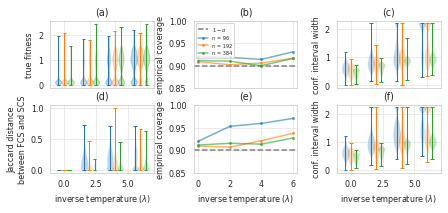

In [28]:
# plot and save figure
save_figure = True
fname = '../figures/100422/figs2-fluorescence.pdf'
alpha = 0.1  # miscoverage
vplot_lw = 1
plot_ms = 2
plot_lw = 1.5

# single-column width: 3.42 inches or 8.7 cm
# double-column width: 7 inches or 17.8 cm
# maximum height: 8.85 inches or 22.5 cm
# small: approx 9 cm x 6 cm (3.54 x 2.36 in)
# medium: approx 11 cm x 11 cm (4.33 in)
# large: approx 18 cm x 22 cm (7 x 8.66 in)
fig, axs = plt.subplots(2, 3, figsize=(7, 2.8))
fig.subplots_adjust(wspace=0.38, hspace=0.25)

# ===== distribution of fitness of designed proteins =====

offsets = [-0.5, 0, 0.5]
colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

for t in range(len(n_trains)):
    ls = [l + offsets[t] for l in lmbdas]
    v = axs[0, 0].violinplot(rfit_txlxs[t].T, ls, widths=0.5, points=200, showextrema=True)
    add_label(v, "n = {}".format(n_trains[t]))
    for pc in v['bodies']:
        pc.set_color(colors[t])
    v['cbars'].set_linewidth(vplot_lw)
    v['cmins'].set_linewidth(vplot_lw)
    v['cmaxes'].set_linewidth(vplot_lw)
    
axs[0, 0].set_xticks(lmbdas)
axs[0, 0].set_xticklabels([])
axs[0, 0].set_ylabel('true fitness');
axs[0, 0].set_title('(a)');


# ===== Jaccard distance between FCS and CS =====

offsets = [-1, 0, 1]
arrl = np.array(lmbdas)
for l, jacc_lxs in enumerate(rjacc_txlxs):
    v = axs[1, 0].violinplot(jacc_lxs.T, arrl + offsets[l] * 0.4, points=200, widths=0.6, showextrema=True)
    v['cbars'].set_linewidth(vplot_lw)
    v['cmins'].set_linewidth(vplot_lw)
    v['cmaxes'].set_linewidth(vplot_lw)
axs[1, 0].set_xlabel(r'inverse temperature ($\lambda$)');
axs[1, 0].set_title('(d)');
axs[1, 0].set_ylabel('Jaccard distance\nbetween FCS and SCS');

# ===== FCS coverage =====

axs[0, 1].axhline(1 - alpha, linestyle="--", color='gray', label=r'$1 - \alpha$')
for t, cov_l in enumerate(rfcov_txl):
    axs[0, 1].plot(lmbdas, cov_l, '-o', markersize=plot_ms, linewidth=plot_lw, alpha=0.6, label='n = {}'.format(n_trains[t]))

axs[0, 1].set_xticks(lmbdas)
axs[0, 1].set_xticklabels([])
axs[0, 1].set_ylabel('empirical coverage');
axs[0, 1].legend(fontsize=5, loc='upper left');
axs[0, 1].set_ylim([0.85, 1]);
axs[0, 1].set_title('(b)');

# ===== FCS interval width =====

for l, len_lxs in enumerate(rflen_txlxs):
    v = axs[0, 2].violinplot(len_lxs.T, arrl + offsets[l] * 0.4, points=1000, widths=0.6, showextrema=True)
    v['cbars'].set_linewidth(vplot_lw)
    v['cmins'].set_linewidth(vplot_lw)
    v['cmaxes'].set_linewidth(vplot_lw)

axs[0, 2].set_ylabel('conf. interval width')
axs[0, 2].set_ylim([-0.1, 2.3]);
axs[0, 2].set_xticks(lmbdas)
axs[0, 2].set_xticklabels([])
axs[0, 2].set_title('(c)');

# ===== SCS coverage =====


axs[1, 1].axhline(1 - alpha, linestyle="--", color='gray', label=r'$1 - \alpha$')
for t, cov_l in enumerate(rscov_txl):
    axs[1, 1].plot(lmbdas, cov_l, '-o', markersize=plot_ms, linewidth=plot_lw, alpha=0.6, label='n = {}'.format(n_trains[t]))
axs[1, 1].set_xlabel(r'inverse temperature ($\lambda$)');
axs[1, 1].set_xticks(lmbdas)
axs[1, 1].set_ylabel('empirical coverage');
axs[1, 1].set_ylim([0.85, 1]);
axs[1, 1].set_title('(e)');

# ===== SCS interval width =====

for l, len_lxs in enumerate(rslen_txlxs):
    v = axs[1, 2].violinplot(len_lxs.T, arrl + offsets[l] * 0.4, points=1000, widths=0.6, showextrema=True)
    v['cbars'].set_linewidth(vplot_lw)
    v['cmins'].set_linewidth(vplot_lw)
    v['cmaxes'].set_linewidth(vplot_lw)

axs[1, 2].set_ylabel('conf. interval width')
axs[1, 2].set_ylim([-0.1, 2.3]);
axs[1, 2].set_xlabel(r'inverse temperature ($\lambda$)');
axs[1, 2].set_title('(f)');

if save_figure:
    plt.savefig(fname, dpi=300, bbox_inches='tight')

## Fig. 4

In [29]:
# trade-off between high predictions and predictive certainty over lambda
n_train = 384
reg = 1
lmbdas = [0, 2, 4, 6]
n_seed = 2000
alpha = 0.1
y_interval = 0.02
bwt = 0.165  # blue fluorescence of one of the wild-type parents, mKate2
rwt = 0.72   # red fluorescence of mKate2

blen_lxs = np.zeros([len(lmbdas), n_seed])
bpred_lxs = np.zeros([len(lmbdas), n_seed])
blb_lxs = np.zeros([len(lmbdas), n_seed])
rlen_lxs = np.zeros([len(lmbdas), n_seed])
rpred_lxs = np.zeros([len(lmbdas), n_seed])
rlb_lxs = np.zeros([len(lmbdas), n_seed])


for l, lmbda in enumerate(lmbdas):
    
    # load blue results
    fname = '../fluorescence/blue_n{}_lambda{}_alpha{}_gamma{}.npz'.format(n_train, lmbda, alpha, reg)
    d = np.load(fname, allow_pickle=True)
    blueset_s = d['fset_s']
    blen_lxs[l] = [cs.size * y_interval for cs in blueset_s]
    blb_lxs[l] = [np.min(cs) > bwt for cs in blueset_s]
    bpred_lxs[l] = d['predtest_s']
    
    # load red results
    fname = '../fluorescence/red_n{}_lambda{}_alpha{}_gamma{}.npz'.format(n_train, lmbda, alpha, reg)
    d = np.load(fname, allow_pickle=True)
    redset_s = d['fset_s']
    rlen_lxs[l] = [cs.size * y_interval for cs in redset_s]
    rlb_lxs[l] = [np.min(cs) > rwt for cs in redset_s]
    rpred_lxs[l] = d['predtest_s']

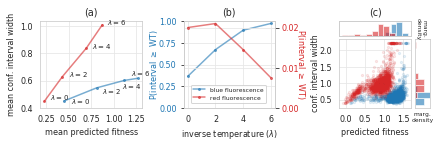

In [34]:
save_figure = True
fname = '../figures/100422/fig4-redvblue.pdf'
plot_ms = 2
plot_lw = 1.5
l_idx = 3  # which lambda to plot

# single-column width: 3.42 inches or 8.7 cm
# double-column width: 7 inches or 17.8 cm
# maximum height: 8.85 inches or 22.5 cm
# small: approx 9 cm x 6 cm (3.54 x 2.36 in)
# medium: approx 11 cm x 11 cm (4.33 in)
# large: approx 18 cm x 22 cm (7 x 8.66 in)
fig = plt.figure(figsize=(7, 1.6))
gs1 = gridspec.GridSpec(1, 3, figure=fig, wspace=0.4)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs1[1 : 3], wspace=0.7)
gs3 = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=gs2[1])

ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs2[0])

ax_joint = fig.add_subplot(gs3[1:5, 0:4])
ax_marg_x = fig.add_subplot(gs3[0, 0:4])
ax_marg_y = fig.add_subplot(gs3[1:5, 4])

# ===== confidence interval width vs. mean predicted fitness =====

bx = np.mean(bpred_lxs, axis=1)
by = np.mean(blen_lxs, axis=1)
rx = np.mean(rpred_lxs, axis=1)
ry = np.mean(rlen_lxs, axis=1)
ax1.plot(bx, by, '-o', c='tab:blue', linewidth=plot_lw, markersize=plot_ms, alpha=0.6, label='blue fluorescence');
ax1.plot(rx, ry, '-o', c='tab:red', linewidth=plot_lw, markersize=plot_ms, alpha=0.6, label='red fluorescence');

ax1.set_xlabel('mean predicted fitness');
ax1.set_xticks([0.25, 0.5, 0.75, 1, 1.25]);
ax1.set_ylabel('mean conf. interval width');
ax1.set_yticks([0.4, 0.6, 0.8, 1.0]);
ax1.legend(bbox_to_anchor=(2.23, 0.3), fontsize=6)

bxoff = [0.08, 0.06, -0.03, -0.08]
byoff = [-0.02, -0.04, -0.06, 0.02]
rxoff = [0.06, 0.07, 0.06, 0.05]
ryoff = [0.01, 0, 0, 0]
for l, lmbda in enumerate(lmbdas):
    ax1.annotate(r'$\lambda = {}$'.format(lmbda), (bx[l] + bxoff[l], by[l] + byoff[l]), fontsize=7)
    ax1.annotate(r'$\lambda = {}$'.format(lmbda), (rx[l] + rxoff[l], ry[l] + ryoff[l]), fontsize=7)
ax1.set_title('(a)')

# ===== p(lb > mkate2) =====

ax3 = ax2.twinx()
ax2.plot(lmbdas, np.mean(blb_lxs, axis=1), '-o', c='tab:blue', markersize=plot_ms, linewidth=plot_lw, alpha=0.6);
ax2.set_xlabel('inverse temperature ($\lambda$)');
ax2.set_xticks([0, 2, 4, 6]);
ax2.set_ylabel('P(interval $\geq$ WT)',color='tab:blue', labelpad=-1);
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1]);
ax2.set_title('(b)')
ax2.set_zorder(-1) # so legend on ax1 shows

ax3.plot(lmbdas, np.mean(rlb_lxs, axis=1), '-o', c='tab:red', markersize=plot_ms, linewidth=plot_lw, alpha=0.6);
ax3.set_yticks([0, 0.01, 0.02]);
ax3.set_ylabel('P(interval $\geq$ WT)', rotation=270, labelpad=7, color='tab:red');
ax3.tick_params(axis='y', labelcolor='tab:red')


# ===== for n = 384, lambda = 6 =====

ax_joint.scatter(bpred_lxs[l_idx], blen_lxs[l_idx] , c='tab:blue', s=5, alpha=0.1);
ax_joint.scatter(rpred_lxs[l_idx], rlen_lxs[l_idx], c='tab:red', s=5, alpha=0.1);
ax_joint.set_xlabel('predicted fitness');
ax_joint.set_xticks([0, 0.5, 1, 1.5]);
ax_joint.set_ylabel('conf. interval width', labelpad=-0.5);
ax_joint.set_yticks([0.5, 1, 1.5, 2]);

ax_marg_x.hist(bpred_lxs[l_idx], bins=10, alpha=0.6)
ax_marg_y.hist(blen_lxs[l_idx], bins=10, alpha=0.6, orientation="horizontal");
ax_marg_x.hist(rpred_lxs[l_idx], color='tab:red', bins=10, alpha=0.6)
ax_marg_y.hist(rlen_lxs[l_idx], color='tab:red', bins=10, alpha=0.6, orientation="horizontal");
ax_marg_x.grid(False)
ax_marg_y.grid(False)
tmp = ax_marg_x.twinx()
ax_marg_x.set_yticks([])
ax_marg_y.set_xlabel('marg.\ndensity', fontsize=6)
tmp.set_ylabel('marg.\ndensity', fontsize=6, rotation=270, labelpad=15)
tmp.grid(False)
tmp.set_yticks([]);
ax_marg_x.yaxis.set_label_coords(0, 0.7)
ax_marg_x.set_title('(c)')


plt.setp(ax_marg_x.get_xticklabels(), visible=False);
plt.setp(ax_marg_y.get_yticklabels(), visible=False);
plt.setp(ax_marg_x.get_yticklabels(), visible=False);
plt.setp(ax_marg_y.get_xticklabels(), visible=False);

plt.savefig(fname, dpi=300, bbox_inches='tight')